# General initialization

In [1]:
# This is a notebook to investigate how to efficiently work with OSMnx for larger areas,
# when sharding the graph calculations.
# Question: is it more efficient to get an OSM graph for a large region, 
# or get it for one triangle at a time, or about the same

from nhstravel.gp import GpArea, GpRegion
from shapely import geometry
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import networkx
import osmnx


In [2]:
%%time
# Common loading code
england = GpRegion.load_england()


/usr/local/google/home/nfortescue/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


CPU times: user 1.2 s, sys: 20.4 ms, total: 1.22 s
Wall time: 1.22 s


In [3]:
# Define a large rectangular area
large_area_poly = geometry.Polygon([ [-0.1,51.52], [-0.07,51.52], [-0.07, 51.4975], [-0.1, 51.4975], [-0.1,51.52]])
# Find all triangles which overlap the larger area
subregion = england.get_subregion(large_area_poly)

Triangles: 39


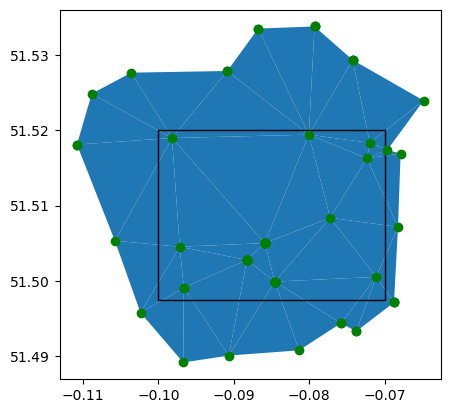

In [4]:
# Display the area we are working on nicely
subregion.pretty_plot(poly=large_area_poly)
print('Triangles: {}'.format(len(subregion._triangulation)))
#plt.savefig('lambeth_subregion.png')

In [5]:
%%time 

# Experiment 1: One region at a time
# To calculate the walking distances for a triangle we need the surrounding triangles
# as some walking routes may leave and enter.
# Attempt 1: My machine CPU 4min 26s total. Longest region 25.7s, shortest 4s. Wall time 7min 43s
# Attempt 2: 3min59s total. Longets region 9.5s, shortest 3.3s. Wall time 4min 1s
import time
for idx, triangle in enumerate(subregion._triangulation):
    t = time.time()
    surrounding_poly = england._polygon_surrounding_triangle(triangle)
    # Load the osm_graph for the area surrounding the triangle
    osmgraph = osmnx.graph_from_polygon(polygon=surrounding_poly, simplify=True, network_type="walk")
    print('--- {}: {} seconds ---'.format(idx, time.time() - t))


--- 0: 4.454637050628662 seconds ---
--- 1: 5.271885633468628 seconds ---
--- 2: 5.505854606628418 seconds ---
--- 3: 4.4583282470703125 seconds ---
--- 4: 4.499513864517212 seconds ---
--- 5: 4.51866888999939 seconds ---
--- 6: 4.625442266464233 seconds ---
--- 7: 5.419910192489624 seconds ---
--- 8: 3.324601173400879 seconds ---
--- 9: 3.6220571994781494 seconds ---
--- 10: 6.835909843444824 seconds ---
--- 11: 7.5054426193237305 seconds ---
--- 12: 7.954829931259155 seconds ---
--- 13: 7.320061445236206 seconds ---
--- 14: 5.616398096084595 seconds ---
--- 15: 3.601867198944092 seconds ---
--- 16: 6.989081382751465 seconds ---
--- 17: 4.667693376541138 seconds ---
--- 18: 3.647702693939209 seconds ---
--- 19: 3.5918500423431396 seconds ---
--- 20: 4.284546136856079 seconds ---
--- 21: 2.9397284984588623 seconds ---
--- 22: 7.404084920883179 seconds ---
--- 23: 7.975969076156616 seconds ---
--- 24: 6.8357367515563965 seconds ---
--- 25: 7.758388996124268 seconds ---
--- 26: 9.2502784

CPU times: user 11.5 s, sys: 400 ms, total: 11.9 s
Wall time: 11.6 s


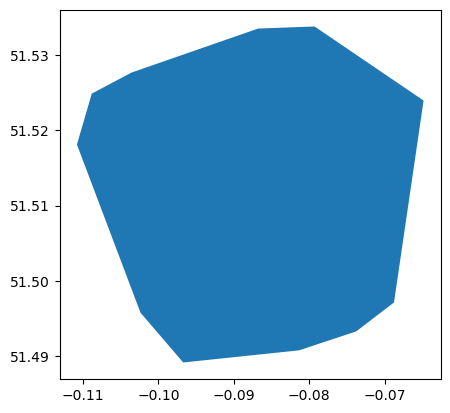

In [33]:
%%time

# Experiment 2: Download the whole convex hull at once.
# Downloading the whole area at once is considerably quicker on my machine. It takes 11s wall time total.
# So it appears osmx download is the bottleneck, and pre-loading the graph is a good idea
ps = [p for triangle in subregion._triangulation for p in triangle.exterior.coords]
poly = geometry.MultiPoint(ps).convex_hull
gpd.GeoSeries(poly).plot()
# Download whole area
osmgraph = osmnx.graph_from_polygon(polygon=poly, simplify=False, network_type="walk")

In [6]:
%%time 

# Experiment 3: If we download the whole area at once, how much time do we spend reducing the downloaded
# area to the smaller polys.
# If we download the whole graph without simplification, then truncate, it takes between 2-3s per triangle,
# 1min49s Wall time total
# With simplification on download, it is around 1s per triangle, and a Wall time of 58s 
# (but presumably a danger of missing nodes)
# So it appears that downloading a larger area then truncating per shard is the optimum strategy.
ps = [p for triangle in subregion._triangulation for p in triangle.exterior.coords]
poly = geometry.MultiPoint(ps).convex_hull
# Download whole area
osmgraph = osmnx.graph_from_polygon(polygon=poly, simplify=False, network_type="walk")

# One download, then truncate by region
import time
for idx, triangle in enumerate(subregion._triangulation):
    t = time.time()
    surrounding_poly = england._polygon_surrounding_triangle(triangle)
    # Load the osm_graph for the area surrounding the triangle
    g = osmnx.truncate.truncate_graph_polygon(osmgraph, surrounding_poly, retain_all=True)
    print('--- {}: {} seconds ---'.format(idx, time.time() - t))


--- 0: 2.5817854404449463 seconds ---
--- 1: 2.3935909271240234 seconds ---
--- 2: 2.3528332710266113 seconds ---
--- 3: 2.3521316051483154 seconds ---
--- 4: 2.309192180633545 seconds ---
--- 5: 2.250978469848633 seconds ---
--- 6: 2.493622303009033 seconds ---
--- 7: 2.1172642707824707 seconds ---
--- 8: 2.3106141090393066 seconds ---
--- 9: 2.3170833587646484 seconds ---
--- 10: 2.6331357955932617 seconds ---
--- 11: 2.222470760345459 seconds ---
--- 12: 2.4022881984710693 seconds ---
--- 13: 2.373481273651123 seconds ---
--- 14: 2.398350477218628 seconds ---
--- 15: 2.3101234436035156 seconds ---
--- 16: 2.354292392730713 seconds ---
--- 17: 2.3724820613861084 seconds ---
--- 18: 2.406892776489258 seconds ---
--- 19: 2.3109874725341797 seconds ---
--- 20: 2.248373508453369 seconds ---
--- 21: 2.2351958751678467 seconds ---
--- 22: 2.4625697135925293 seconds ---
--- 23: 2.1318767070770264 seconds ---
--- 24: 2.303194999694824 seconds ---
--- 25: 2.297072410583496 seconds ---
--- 26: